# Notebook Initialization

In [1]:
# %load nb_init.py

from pathlib import Path
import pandas as pd

base_dir = Path.cwd().parent
config_dir = base_dir / "config"
data_dir = base_dir / "data"
docs_dir = base_dir / "docs"
figures_dir = docs_dir / "figures"
models_dir = base_dir / "models"
logs_dir = base_dir / "logs"
images_input_dir = data_dir / "COVID19"
preprocessed_dir = data_dir / "preprocessed"
output_dir = data_dir / "output"

# Directories used to train the CNN (image by image) 
cnn_data_dir = data_dir / "modelling" / "cnn"
cnn_train_dir = cnn_data_dir / "train"
cnn_test_dir = cnn_data_dir / "test"

metadata_file = images_input_dir / "metadata.csv"
labels_file = images_input_dir / "unzip_filenames.csv"
preprocessed_labels_file = preprocessed_dir / "labels.parquet"

feature_extractor_model_file = models_dir / "feature_extractor.tf"

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.getOrCreate()

config_file = config_dir / "tfg.conf"

from pyhocon import ConfigFactory
config = None

def load_config():
    return ConfigFactory.parse_file(config_file)

config = load_config()
    
import sys

if str(base_dir / "src") not in sys.path:
    sys.path.append(str(base_dir / "src"))

%load_ext autoreload

%autoreload 2

In [2]:
spark

In [3]:
from tfg import DataRepository

repo = DataRepository(config=config, base_data_path=data_dir)

# Load datasets

In [4]:
import numpy as np

In [5]:
class_idx = {'CP': 0, 'NCP': 1, 'Normal': 2}
idx_to_class = { v: k for k, v in class_idx.items() }

In [6]:
train_clips = repo.load("train_clips_final")
train_clips.head(5)

,patient_id,scan_id,label,n_slice,clip_num,clip_start_file,clip_end_file,seq_features
0,0,3131,CP,285,0,CP/0/3131/0000.png,CP/0/3131/0069.png,"[[0.6799156665802002, 0.7049319744110107, 0.28..."
1,0,3131,CP,285,1,CP/0/3131/0070.png,CP/0/3131/0139.png,"[[0.6799156665802002, 0.7049319744110107, 0.28..."
2,0,3131,CP,285,2,CP/0/3131/0140.png,CP/0/3131/0209.png,"[[0.46724724769592285, 0.48773252964019775, 0...."
3,0,3131,CP,285,3,CP/0/3131/0210.png,CP/0/3131/0279.png,"[[0.722501277923584, 0.7558450698852539, 0.082..."
4,0,3131,CP,285,4,CP/0/3131/0280.png,CP/0/3131/0284.png,"[[0.6799156665802002, 0.7049319744110107, 0.28..."


In [7]:
def to_single_nparr(arrs):
    return np.array([el.tolist() for el  in arrs.tolist()])

def ohe_label(label):
    ohe_labels = [0, 0, 0]
    ohe_labels[class_idx[label]] = 1
    
    return np.array(ohe_labels)

In [8]:
train_targets = train_clips["label"].apply(ohe_label).values
train_targets = to_single_nparr(train_targets)
train_targets[:5], train_targets[-5:]

(array([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]]),
 array([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]]))

In [9]:
train_data = train_clips["seq_features"].apply(to_single_nparr).values
train_data[:1], train_data[-1:]

(array([array([[0.67991567, 0.70493197, 0.2860862 , ..., 0.56854105, 0.55904984,
         0.77386147],
        [0.67991567, 0.70493197, 0.2860862 , ..., 0.56854105, 0.55904984,
         0.77386147],
        [0.68146181, 0.70675421, 0.28294927, ..., 0.56978416, 0.56019735,
         0.77570766],
        ...,
        [0.68598747, 0.71208799, 0.27376705, ..., 0.57342315, 0.56355625,
         0.78111178],
        [0.68173325, 0.70707405, 0.28239852, ..., 0.57000244, 0.56039882,
         0.77603179],
        [0.67991567, 0.70493197, 0.2860862 , ..., 0.56854105, 0.55904984,
         0.77386147]])], dtype=object),
 array([array([[6.62039042e-01, 6.86483979e-01, 2.92236567e-01, 6.74647808e-01,
         1.01699568e-02, 6.40773177e-01, 6.37786984e-01, 5.24150133e-01,
         2.94368714e-01, 9.30819660e-04, 0.00000000e+00, 8.25745985e-04,
         0.00000000e+00, 5.52753210e-01, 5.46012282e-01, 7.52921104e-01],
        [6.62039042e-01, 6.86483979e-01, 2.92236567e-01, 6.74647808e-01,
         1.01

In [10]:
train_data.shape

(6117,)

In [11]:
train_data[0].shape

(70, 16)

In [12]:
num_obs, seq_length, num_feats = train_data.shape[0], train_data[0].shape[0], train_data[0].shape[1]
new_shape = (num_obs, seq_length, num_feats)
new_training_data = np.zeros(new_shape)
new_training_data.shape

(6117, 70, 16)

In [13]:
# With this we make sure that the final data is a single numpy array
for idx, obs in enumerate(train_data):
    if len(obs) < seq_length:
        for feat_idx, feats in enumerate(obs):
            new_training_data[idx][feat_idx] = feats
    else:
        new_training_data[idx] = obs

In [14]:
val_clips = repo.load("val_clips_final")
val_clips.head(5)

,patient_id,scan_id,label,n_slice,clip_num,clip_start_file,clip_end_file,seq_features
0,4,3505,CP,298,0,CP/4/3505/0000.png,CP/4/3505/0069.png,"[[0.662039041519165, 0.6864839792251587, 0.292..."
1,4,3505,CP,298,1,CP/4/3505/0070.png,CP/4/3505/0139.png,"[[0.6640641689300537, 0.6885329484939575, 0.29..."
2,4,3505,CP,298,2,CP/4/3505/0140.png,CP/4/3505/0209.png,"[[0.6527369022369385, 0.6770719289779663, 0.29..."
3,4,3505,CP,298,3,CP/4/3505/0210.png,CP/4/3505/0279.png,"[[0.6671477556228638, 0.6916530132293701, 0.29..."
4,4,3505,CP,298,4,CP/4/3505/0280.png,CP/4/3505/0297.png,"[[0.66166752576828, 0.6861080527305603, 0.2922..."


In [15]:
val_targets = val_clips["label"].apply(ohe_label).values
val_targets = to_single_nparr(val_targets)
val_targets[:5], val_targets[-5:]

(array([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]]),
 array([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]]))

In [16]:
val_data = val_clips["seq_features"].apply(to_single_nparr).values
val_data[:1], val_data[-1:]

(array([array([[0.66203904, 0.68648398, 0.29223657, ..., 0.55275321, 0.54601228,
         0.7529211 ],
        [0.63767254, 0.66187155, 0.29424131, ..., 0.53098387, 0.52837461,
         0.72451556],
        [0.6181857 , 0.64241862, 0.29319417, ..., 0.51357138, 0.5144847 ,
         0.701774  ],
        ...,
        [0.66311443, 0.687572  , 0.29207671, ..., 0.55371368, 0.54679739,
         0.75417387],
        [0.66430569, 0.68877745, 0.29189959, ..., 0.55477774, 0.54766732,
         0.75556171],
        [0.66393149, 0.68839872, 0.29195523, ..., 0.55444348, 0.54739404,
         0.75512576]])], dtype=object),
 array([array([[3.79824847e-01, 3.89688313e-01, 1.54758871e-01, 4.16592002e-01,
         0.00000000e+00, 3.88488919e-01, 3.73142451e-01, 3.32797498e-01,
         2.12230861e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 2.79411077e-01, 3.11003327e-01, 4.27306592e-01],
        [3.24434161e-01, 3.40244859e-01, 0.00000000e+00, 2.95565486e-01,
         0.00

In [17]:
num_val_obs = val_data.shape[0]
new_val_shape = (num_val_obs, seq_length, num_feats)
new_val_data = np.zeros(new_val_shape)
new_val_data.shape

(744, 70, 16)

In [18]:
# With this we make sure that the final data is a single numpy array
for idx, obs in enumerate(val_data):
    if len(obs) < seq_length:
        for feat_idx, feats in enumerate(obs):
            new_val_data[idx][feat_idx] = feats
    else:
        new_val_data[idx] = obs

# Create model

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
num_models = 1
rnn_model_suffix = f"{num_models:02d}"
rnn_model_dir = models_dir / f"rnn_{rnn_model_suffix}"

while rnn_model_dir.exists():
    num_models += 1
    rnn_model_suffix = f"{num_models:02d}"
    rnn_model_dir = models_dir / f"rnn_{rnn_model_suffix}"

print(f"RNN Model dir: {rnn_model_dir}")
print(f"{rnn_model_suffix = }")

rnn_model_dir.mkdir(exist_ok=True)
rnn_checkpoint_dir = rnn_model_dir / "checkpoint"
rnn_checkpoint_dir.mkdir(exist_ok=True)

rnn_logs_dir = logs_dir / f"rnn_{rnn_model_suffix}"
rnn_logs_dir.mkdir()


In [64]:
from tensorflow.keras import callbacks

checkpointer = callbacks.ModelCheckpoint(
    str(rnn_checkpoint_dir),
    monitor="val_categorical_accuracy",
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch"
)

tensorboard_logger = callbacks.TensorBoard(
    log_dir=str(rnn_logs_dir),
    histogram_freq=1,
    write_graph=False,
    write_images=False,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None
)

model_callbacks = [checkpointer, tensorboard_logger]
#model_callbacks = [checkpointer]

RNN Model dir: /home/albert/projects/tfg/models/rnn_02
rnn_model_suffix = '02'


In [65]:
model = keras.Sequential()

num_recurrent_units = 8
seq_length = 70

model.add(
    layers.Bidirectional(layers.GRU(num_recurrent_units, return_sequences=False), input_shape=(seq_length, num_feats), name="gru_bidirect_1")
)
# model.add(layers.Bidirectional(layers.GRU(num_recurrent_units // 2), name="gru_bidirect_2"))
# model.add(
#     layers.GRU(64, return_sequences=True, input_shape=(seq_length, num_features))
# )
# model.add(layers.GRU(num_features // 2))

# #model.add(layers.GRU(num_recurrent_units // 2, name="gru_bidirect_2"))
# model.add(layers.Bidirectional(layers.GRU(num_recurrent_units // 2), name="gru_bidirect_2"))

model.add(layers.Dense(3))#min(10, num_recurrent_units // 2))
model.add(layers.Dense(3))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_bidirect_1 (Bidirectiona (None, 16)                1248      
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 51        
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 12        
Total params: 1,311
Trainable params: 1,311
Non-trainable params: 0
_________________________________________________________________


In [66]:
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['categorical_accuracy'])

In [67]:
fit_history = model.fit(
    x=new_training_data, y=train_targets,
    batch_size=32, epochs=20,
    verbose=1,
    validation_data=(new_val_data, val_targets),
    callbacks=model_callbacks
)

Epoch 1/20
190/192 [============================>.] - ETA: 0s - loss: 2.0571 - categorical_accuracy: 0.3296
Epoch 00001: val_categorical_accuracy improved from -inf to 0.38710, saving model to /home/albert/projects/tfg/models/rnn_02/checkpoint
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/albert/projects/tfg/models/rnn_02/checkpoint/assets
192/192 [==============================] - 9s 47ms/step - loss: 2.0619 - categorical_accuracy: 0.3296 - val_loss: 2.4266 - val_categorical_accuracy: 0.3871
Epoch 2/20
185/192 [===========================>..] - ETA: 0s - loss: 2.1873 - categorical_accuracy: 0.3402
Epoch 00002: val_categorical_accuracy improved from 0.38710 to 0.42339, saving model to /home/albert/projects/tfg/models/rnn_02/checkpoint
INFO:tensorflow:Assets written to: /home/albert/projects/tfg/models/rnn_02/checkpoint/assets
192/192 [==============================] - 9s 46ms/step - loss: 2.1918 - categorical_a

In [71]:
from tensorflow.keras.models import load_model

del model
model = load_model(str(rnn_checkpoint_dir))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_bidirect_1 (Bidirectiona (None, 16)                1248      
_________________________________________________________________
dense_26 (Dense)             (None, 3)                 51        
_________________________________________________________________
dense_27 (Dense)             (None, 3)                 12        
Total params: 1,311
Trainable params: 1,311
Non-trainable params: 0
_________________________________________________________________


# Evaluation of the different sets

In [72]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(13, 9)})

In [73]:
import numpy as np
import itertools

sns.set_style("whitegrid", {'axes.grid' : False})

# based on answer from https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python
def plot_confusion_matrix(cm, classes,
                          save_to=None,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontdict={'fontsize' : 26})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=18)
    plt.yticks(tick_marks, classes, fontsize=18)

    fmt_pct = lambda pct: f"{100 * pct:.2f}%" if normalize else f"{int(100 * pct)}%"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, fmt_pct(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontdict={'fontsize' : 16})

    plt.ylabel('True label', fontdict={'fontsize' : 22})
    plt.xlabel('Predicted label', fontdict={'fontsize' : 22})
    plt.tight_layout()
    
    if save_to:
        plt.savefig(save_to)

In [74]:
def print_metrics(dataset, true_labels, pred_labels):
    prec, rec, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average="weighted")
    print(f"{dataset} F1 Score: {100 * f1: .2f}%")
    print(f"{dataset} Precision: {100 * prec: .2f}%")
    print(f"{dataset} Recall: {100 * rec: .2f}%")

In [75]:
class_to_idx = {'CP': 0, 'NCP': 1, 'Normal': 2}
idx_to_class = { v: k for k, v in class_to_idx.items() }
class_labels = [k for k in class_to_idx.keys()]

## Training

192/192 [==============================] - 1s 3ms/step
Normalized confusion matrix
[[0.96352584 0.00868432 0.02778984]
 [0.09111617 0.76993166 0.13895216]
 [0.3267449  0.001853   0.6714021 ]]


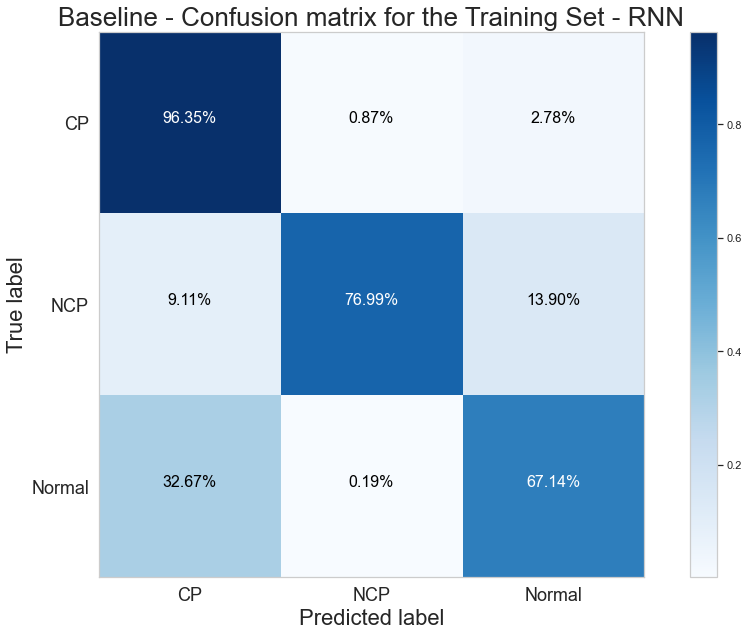

In [76]:
raw_train_preds = model.predict(new_training_data, verbose=1)
train_preds = raw_train_preds.argmax(axis=1)
train_true = train_targets.argmax(axis=1)

train_cm = confusion_matrix(train_true, train_preds)

plot_confusion_matrix(
    train_cm,
    classes=class_labels,
    title='Baseline - Confusion matrix for the Training Set - RNN',
    save_to=figures_dir / "models" / "rnn_feats" / f"train_conf_matrix.png")

In [80]:
print_metrics("Training", train_true, train_preds)

Training F1 Score:  81.57%
Training Precision:  83.50%
Training Recall:  81.67%


## Validation

24/24 [==============================] - 0s 3ms/step
Normalized confusion matrix
[[0.96271186 0.02033898 0.01694915]
 [0.08029197 0.81021898 0.10948905]
 [0.34857143 0.         0.65142857]]


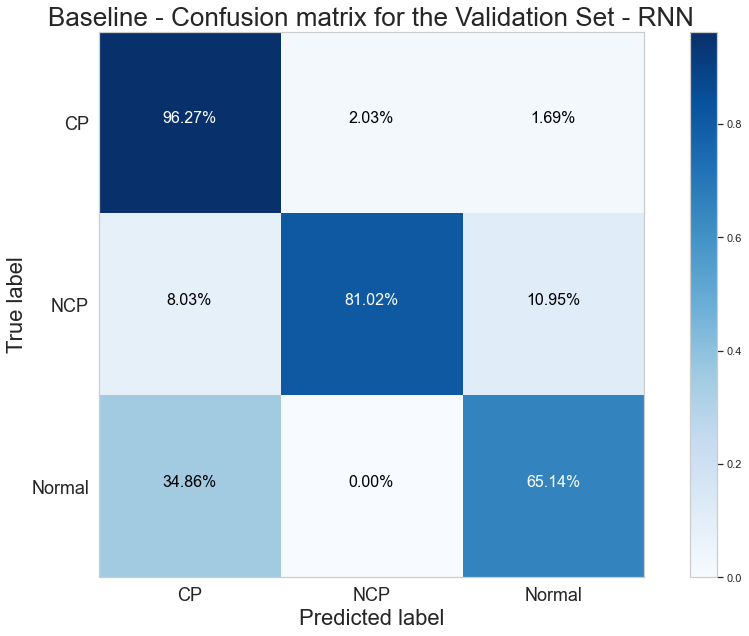

In [77]:
raw_val_preds = model.predict(new_val_data, verbose=1)
val_preds = raw_val_preds.argmax(axis=1)
val_true = val_targets.argmax(axis=1)

val_cm = confusion_matrix(val_true, val_preds)

plot_confusion_matrix(
    val_cm,
    classes=class_labels,
    title='Baseline - Confusion matrix for the Validation Set - RNN',
    save_to=figures_dir / "models" / "rnn_feats" / f"val_conf_matrix.png")

In [82]:
print_metrics("Validation", val_true, val_preds)

Validation F1 Score:  83.15%
Validation Precision:  84.54%
Validation Recall:  83.33%


## Test

In [78]:
test_clips = repo.load("test_clips_final")
test_clips.head(5)

test_targets = test_clips["label"].apply(ohe_label).values
test_targets = to_single_nparr(test_targets)

test_data = test_clips["seq_features"].apply(to_single_nparr).values

num_test_obs = test_data.shape[0]
new_test_shape = (num_test_obs, seq_length, num_feats)
new_test_data = np.zeros(new_test_shape)
new_test_data.shape

# With this we make sure that the final data is a single numpy array
for idx, obs in enumerate(test_data):
    if len(obs) < seq_length:
        for feat_idx, feats in enumerate(obs):
            new_test_data[idx][feat_idx] = feats
    else:
        new_test_data[idx] = obs

24/24 [==============================] - 0s 3ms/step
Normalized confusion matrix
[[0.9704918  0.00655738 0.02295082]
 [0.11032028 0.77580071 0.113879  ]
 [0.19879518 0.0060241  0.79518072]]


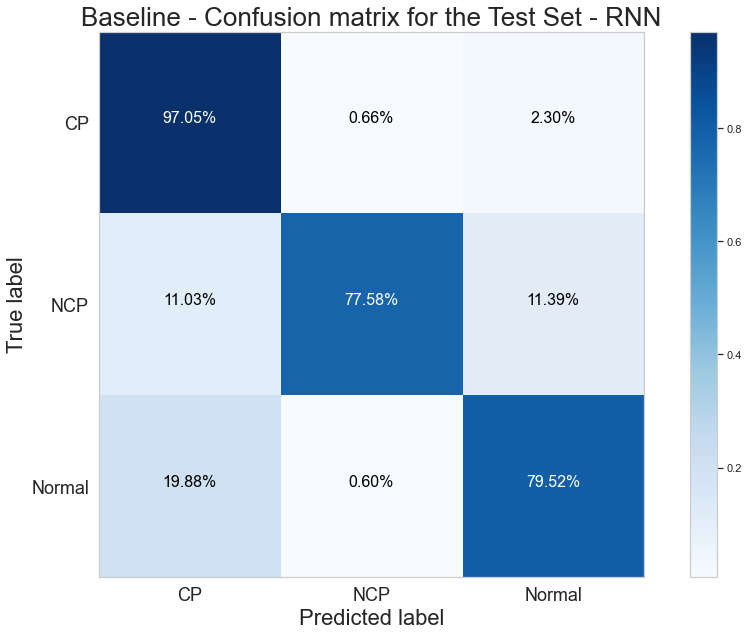

In [79]:
raw_test_preds = model.predict(new_test_data, verbose=1)
test_preds = raw_test_preds.argmax(axis=1)
test_true = test_targets.argmax(axis=1)

test_cm = confusion_matrix(test_true, test_preds)

plot_confusion_matrix(
    test_cm,
    classes=class_labels,
    title='Baseline - Confusion matrix for the Test Set - RNN',
    save_to=figures_dir / "models" / "rnn_feats" / f"test_conf_matrix.png")

In [83]:
print_metrics("Test", test_true, test_preds)

Test F1 Score:  85.85%
Test Precision:  87.25%
Test Recall:  85.90%
